# Механізм уваги для обробки тестів

[Оригінальна стаття](chrome-extension://efaidnbmnnnibpcajpcglclefindmkaj/https://arxiv.org/pdf/1706.03762.pdf)

Механізми уваги зробили революцію в обробці природної мови (NLP), дозволивши моделям зосередитися на найбільш релевантних частинах вхідної послідовності. У цьому посібнику розглядаються поняття уваги, багатоголової уваги та кодерів-трансформерів у PyTorch для задач NLP.

Розуміння уваги:

Уявіть, що ви читаєте речення. Ви не приділяєте однакову увагу кожному слову, а зосереджуєтесь на найбільш важливих, щоб зрозуміти зміст. Аналогічно, увага в моделях НЛП дозволяє моделі концентруватися на певних частинах вхідної послідовності (наприклад, реченні), які є найбільш важливими для конкретного завдання, наприклад, аналізу настрою або машинного перекладу.


<div>
<img src="https://preview.redd.it/nrd3yld06rr91.png?width=761&format=png&auto=webp&s=76b11148418849a21304943898526dbdfb60052c" width="500"/>
</div>

## Ключові поняття:

* **Вектори запиту, ключа та значення:** Модель отримує на вхід 3 тензора: запит, ключ і значення. Вони відображають різні аспекти елементів послідовності.
* **Ймовірність уваги:** Модель обчислює оцінку для кожної пари елементів у послідовності. Ця оцінка й відображає, наскільки важливим є один елемент (на основі його вектора ключа) для поточного елемента (на основі його вектора запиту).
* **Зважена сума:** Використовуючи оцінки уваги, модель створює зважену суму векторів значень, ефективно фокусуючись на найбільш релевантних частинах послідовності.

**Переваги уваги:** 

* **Довгострокові залежності:** Увага допомагає вловлювати довгострокові залежності в тексті, де віддалені слова можуть бути семантично пов'язані між собою. Це має вирішальне значення для таких завдань, як відповіді на запитання або аналіз настроїв.
* **Розпаралелювання:** Обчислення уваги можна ефективно розпаралелити, що робить їх придатними для навчання на великих наборах даних за допомогою графічних процесорів.

![](https://www.researchgate.net/publication/356271104/figure/fig5/AS:1090999354961922@1637125924695/The-general-process-of-attention-mechanism.png)

# Багатоголова увага

Стандартний механізм уваги фокусується на одному аспекті взаємозв'язків між елементами. Багатоголова увага вирішує цю проблему, виконуючи увагу з декількох «голів», кожна з яких вивчає різні представлення взаємозв'язків. Це дозволяє моделі відображати більш глибоке розуміння вхідної послідовності.

![](https://miro.medium.com/v2/resize:fit:1400/1*PiZyU-_J_nWixsTjXOUP7Q.png)

# Модель Трансформер

Трансформаторна архітектура, популярний вибір для завдань НЛП, значною мірою покладається на механізми уваги. Кодер Transformer використовує шари багатоголової уваги з наступними мережами прямого поширення. Ці шари дозволяють моделі вивчати складні взаємозв'язки між елементами вхідної послідовності.

![](https://quantdare.com/wp-content/uploads/2021/11/transformer_arch.png)

# Читання даних

In [1]:
import torch
device = "cuda" if torch.cuda.is_available() else "cpu"

In [2]:
import pandas as pd

df = pd.read_csv("/kaggle/input/bbc-full-text-document-classification/bbc_data.csv")
df.head()

,data,labels
0,Musicians to tackle US red tape Musicians gro...,entertainment
1,"U2s desire to be number one U2, who have won ...",entertainment
2,Rocker Doherty in on-stage fight Rock singer ...,entertainment
3,Snicket tops US box office chart The film ada...,entertainment
4,"Oceans Twelve raids box office Oceans Twelve,...",entertainment


# [Посилання на Glove](https://github.com/stanfordnlp/GloVe?tab=readme-ov-file)

In [7]:
from torch.utils.data import Dataset
from sklearn.preprocessing import LabelEncoder
import torchtext


class MyDataset(Dataset):
    def __init__(self, X, y, max_len=100):
        self.X = X
        self.y = y
        self.max_len = max_len
        
        self.label_encoder = LabelEncoder().fit(y)
        #self.vocab = torchtext.vocab.GloVe(name='6B', dim=50)
        self.vocab = torchtext.vocab.Vectors("/kaggle/input/glove6b/glove.6B.50d.txt")

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        label = self.label_encoder.transform([self.y.iloc[idx]])
        label = torch.tensor(label)
        
        text = self.X.iloc[idx]
        tokens = text.split()
        
        if len(tokens) > self.max_len:
            tokens = tokens[:self.max_len]
        else:
            diff = self.max_len - len(tokens)
            
            tokens += ['<pad>'] * diff
        
        X = self.vocab.get_vecs_by_tokens(tokens, lower_case_backup=True)
        
        return X, label[0]
    
    
dataset = MyDataset(df['data'], df['labels'])

100%|█████████▉| 400000/400001 [00:15<00:00, 25102.88it/s]


In [8]:
dataset[0][0].shape

torch.Size([100, 50])

In [9]:
from torch.utils.data import random_split

train_ratio = 0.8

# Розділіть набір даних
train_data, test_data = random_split(dataset, [train_ratio, 1-train_ratio])

In [10]:
from torch.utils.data import DataLoader

batch_size = 32

train_loader = torch.utils.data.DataLoader(train_data, shuffle=True, batch_size=batch_size)
test_loader = torch.utils.data.DataLoader(test_data, shuffle=True, batch_size=batch_size)

# Створення моделі

In [11]:
from torch import nn
import torch.nn.functional as F
import numpy as np


class TextClassifier(nn.Module):
    def __init__(self, encoding_dim=50, max_len=100, num_classes):
        super().__init__()

        self.encoder = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(d_model=encoding_dim, nhead=2, batch_first=True, dim_feedforward=64),
            num_layers=1
        )

        self.flatten = nn.Flatten()

        self.linear1 = nn.Linear(encoding_dim*max_len, num_classes)

    def forward(self, x):
        out = self.encoder(x)
        out = self.flatten(out)
        out = self.linear1(out)
        return out


    def predict(self, X, device='cpu'):
        X = torch.FloatTensor(np.array(X)).to(device)

        with torch.no_grad():
            y_pred = F.softmax(self.forward(X), dim=-1)

        return y_pred.cpu().numpy()


model = TextClassifier(num_classes=5).to(device)
model

TextClassifier(
  (encoder): TransformerEncoder(
    (layers): ModuleList(
      (0): TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=50, out_features=50, bias=True)
        )
        (linear1): Linear(in_features=50, out_features=64, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=64, out_features=50, bias=True)
        (norm1): LayerNorm((50,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((50,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear1): Linear(in_features=5000, out_features=5, bias=True)
)

## Кількість параметрів

In [21]:
params_num = 0

for param in model.parameters():
    size = param.size()
    
    num = 1
    for item in size:
        num *= item
    params_num += num

params_num

41919

In [25]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=0.0001)

In [26]:
import time

def train(model, optimizer, loss_fn, train_dl, val_dl,
          metrics=None, metrics_name=None, epochs=20, device='cpu', task='regression'):
    '''
    Runs training loop for classification problems. Returns Keras-style
    per-epoch history of loss and accuracy over training and validation data.

    Parameters
    ----------
    model : nn.Module
        Neural network model
    optimizer : torch.optim.Optimizer
        Search space optimizer (e.g. Adam)
    loss_fn :
        Loss function (e.g. nn.CrossEntropyLoss())
    train_dl :
        Iterable dataloader for training data.
    val_dl :
        Iterable dataloader for validation data.
    metrics: list
        List of sklearn metrics functions to be calculated
    metrics_name: list
        List of matrics names
    epochs : int
        Number of epochs to run
    device : string
        Specifies 'cuda' or 'cpu'
    task : string
        type of problem. It can be regression, binary or multiclass

    Returns
    -------
    Dictionary
        Similar to Keras' fit(), the output dictionary contains per-epoch
        history of training loss, training accuracy, validation loss, and
        validation accuracy.
    '''

    print('train() called: model=%s, opt=%s(lr=%f), epochs=%d, device=%s\n' % \
          (type(model).__name__, type(optimizer).__name__,
           optimizer.param_groups[0]['lr'], epochs, device))

    metrics = metrics if metrics else []
    metrics_name = metrics_name if metrics_name else [metric.__name__ for metric in metrics]

    history = {} # Collects per-epoch loss and metrics like Keras' fit().
    history['loss'] = []
    history['val_loss'] = []
    for name in metrics_name:
        history[name] = []
        history[f'val_{name}'] = []

    start_time_train = time.time()

    for epoch in range(epochs):

        # --- TRAIN AND EVALUATE ON TRAINING SET -----------------------------
        start_time_epoch = time.time()

        model.train()
        history_train = {name: 0 for name in ['loss']+metrics_name}

        for batch in train_dl:
            x    = batch[0].to(device)
            y    = batch[1].to(device)
            y_pred = model(x)
            loss = loss_fn(y_pred, y)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            y_pred = y_pred.detach().cpu().numpy()
            y = y.detach().cpu().numpy()


            history_train['loss'] += loss.item() * x.size(0)
            for name, func in zip(metrics_name, metrics):
              try:
                  history_train[name] += func(y, y_pred) * x.size(0)
              except:
                  if task == 'binary': y_pred_ = y_pred.round()
                  elif task == 'multiclass': y_pred_ = y_pred.argmax(axis=-1)
                  history_train[name] += func(y, y_pred_) * x.size(0)

        for name in history_train:
            history_train[name] /= len(train_dl.dataset)


        # --- EVALUATE ON VALIDATION SET -------------------------------------
        model.eval()
        history_val = {'val_' + name: 0 for name in metrics_name+['loss']}

        with torch.no_grad():
            for batch in val_dl:
                x    = batch[0].to(device)
                y    = batch[1].to(device)
                y_pred = model(x)
                loss = loss_fn(y_pred, y)

                y_pred = y_pred.cpu().numpy()
                y = y.cpu().numpy()

                history_val['val_loss'] += loss.item() * x.size(0)
                for name, func in zip(metrics_name, metrics):
                    try:
                        history_val['val_'+name] += func(y, y_pred) * x.size(0)
                    except:
                        if task == 'binary': y_pred_ = y_pred.round()
                        elif task == 'multiclass': y_pred_ = y_pred.argmax(axis=-1)

                        history_val['val_'+name] += func(y, y_pred_) * x.size(0)

        for name in history_val:
            history_val[name] /= len(val_dl.dataset)

        # PRINTING RESULTS

        end_time_epoch = time.time()

        for name in history_train:
            history[name].append(history_train[name])
            history['val_'+name].append(history_val['val_'+name])

        total_time_epoch = end_time_epoch - start_time_epoch

        print(f'Epoch {epoch+1:4d} {total_time_epoch:4.0f}sec', end='\t')
        for name in history_train:
            print(f'{name}: {history[name][-1]:10.3g}', end='\t')
            print(f"val_{name}: {history['val_'+name][-1]:10.3g}", end='\t')
        print()

    # END OF TRAINING LOOP

    end_time_train       = time.time()
    total_time_train     = end_time_train - start_time_train
    print()
    print('Time total:     %5.2f sec' % (total_time_train))

    return history

In [27]:
from sklearn.metrics import accuracy_score, roc_auc_score

history = train(model, optimizer, loss_fn, train_loader, test_loader,
                epochs=10,
                metrics=[accuracy_score],
                device=device,
                task='multiclass')

train() called: model=TextClassifier, opt=Adam(lr=0.001000), epochs=5, device=cuda

Epoch    1    3sec	loss:      0.615	val_loss:      0.207	accuracy_score:      0.761	val_accuracy_score:      0.919	
Epoch    2    2sec	loss:     0.0862	val_loss:      0.202	accuracy_score:      0.977	val_accuracy_score:      0.935	
Epoch    3    2sec	loss:      0.022	val_loss:      0.184	accuracy_score:      0.998	val_accuracy_score:      0.939	
Epoch    4    2sec	loss:    0.00796	val_loss:      0.187	accuracy_score:          1	val_accuracy_score:      0.948	
Epoch    5    2sec	loss:    0.00457	val_loss:       0.19	accuracy_score:          1	val_accuracy_score:      0.944	

Time total:      9.34 sec


# Результати

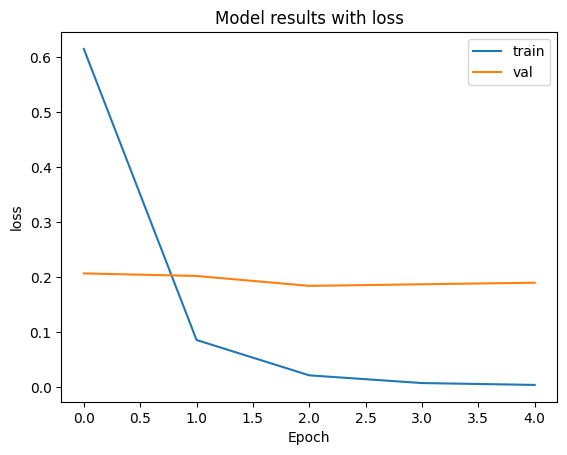

In [28]:
import matplotlib.pyplot as plt

def plot_metric(history, name):
    plt.title(f"Model results with {name}")
    plt.plot(history[name], label='train')
    plt.plot(history['val_'+name], label='val')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    plt.legend()


plot_metric(history, 'loss')

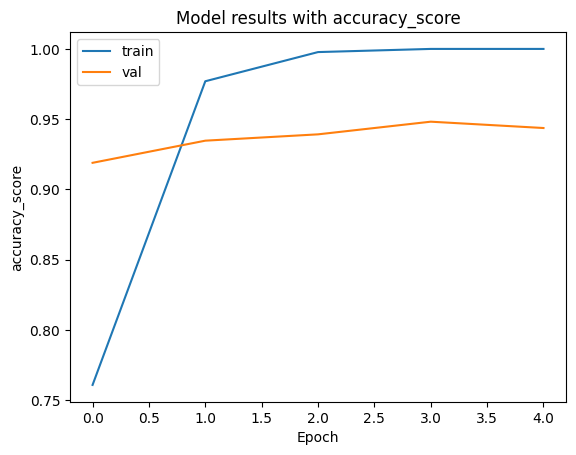

In [29]:
plot_metric(history, 'accuracy_score')

[]

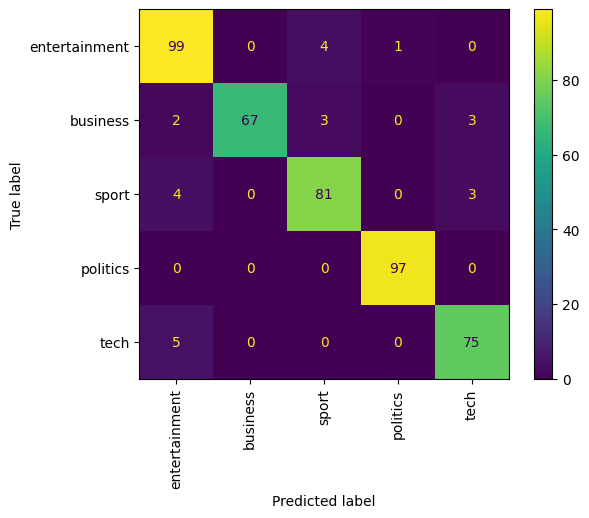

In [36]:
from sklearn.metrics import ConfusionMatrixDisplay

model = model.to('cpu')  # відключаємо від gpu

loader = torch.utils.data.DataLoader(test_data, batch_size=len(test_data))
X_test, y_test = next(iter(loader))

y_pred = model.predict(X_test)

ConfusionMatrixDisplay.from_predictions(y_test, y_pred.argmax(-1), display_labels=df['labels'].unique())
plt.xticks(rotation=90)
plt.plot()

In [37]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred.argmax(-1), target_names=df['labels'].unique()))

               precision    recall  f1-score   support

entertainment       0.90      0.95      0.93       104
     business       1.00      0.89      0.94        75
        sport       0.92      0.92      0.92        88
     politics       0.99      1.00      0.99        97
         tech       0.93      0.94      0.93        80

     accuracy                           0.94       444
    macro avg       0.95      0.94      0.94       444
 weighted avg       0.95      0.94      0.94       444

